# This script contains the following:
1. Import libraries and data
2. Subsetting, wrangling and cleaning the time-series data
3. Time-series analysis: decomposition
4. Testing for stationarity
5. Stationarising the World Happiness report data

## 1. Import libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
from fredapi import Fred
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings 

plt.style.use('fivethirtyeight')

In [2]:
# Ensures the graphs created are displayed

%matplotlib inline

In [3]:
# Define path
path = r'/Users/ianfleming/Desktop/World Happiness Report Analysis'

In [4]:
# Import data
df = pd.read_csv(os.path.join(path,'02 Data','Prepared Data','world_happiness.csv'),index_col=0)

In [5]:
df.head()

,country_name,regional_indicator,year,life_ladder,log_gdp_per_capita,social_support,healthy_life_expectancy_at_birth,freedom_to_make_life_choices,generosity,perceptions_of_corruption,positive_affect,negative_affect,confidence_in_national_government,conf_gov_missing,happiness_category,cluster
0,Afghanistan,South Asia,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195,0.612072,0,Low,1
1,Afghanistan,South Asia,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092,0.611545,0,Medium,1
2,Afghanistan,South Asia,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324,0.299357,0,Medium,1
3,Afghanistan,South Asia,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175,0.307386,0,Low,1
4,Afghanistan,South Asia,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919,0.435440,0,Low,1


In [6]:
df.shape

(2199, 16)

In [7]:
df.columns

Index(['country_name', 'regional_indicator', 'year', 'life_ladder',
       'log_gdp_per_capita', 'social_support',
       'healthy_life_expectancy_at_birth', 'freedom_to_make_life_choices',
       'generosity', 'perceptions_of_corruption', 'positive_affect',
       'negative_affect', 'confidence_in_national_government',
       'conf_gov_missing', 'happiness_category', 'cluster'],
      dtype='object')

## 2. Subsetting, wrangling and cleaning the time series data

In [8]:
# Filter for Germany
germany = df[df['country_name'] == 'Germany'].copy()

# Set Year as datetime index
germany['year'] = pd.to_datetime(germany['year'], format='%Y')
germany = germany.set_index('year')

# Choose Log GDP per capita as the time series
ts = germany['log_gdp_per_capita']

print(ts)



year
2005-01-01    10.690792
2007-01-01    10.760041
2008-01-01    10.771496
2009-01-01    10.715405
2010-01-01    10.757887
2011-01-01    10.814925
2012-01-01    10.817224
2013-01-01    10.818861
2014-01-01    10.836548
2015-01-01    10.842699
2016-01-01    10.856683
2017-01-01    10.879395
2018-01-01    10.886154
2019-01-01    10.894409
2020-01-01    10.855924
2021-01-01    10.881432
2022-01-01    10.898526
Name: log_gdp_per_capita, dtype: float64


### There is no record for 2006

I subset the data to Germany and selected log_gdp_per_capita (2005–2022). Year was converted to datetime and set as the index. I chose Germany and log_gdp_per_capita and the years 2005–2022 because they are the observed historical values relevant to my hypothesis.

In [9]:
# Check for missing values
ts.isna().sum()


0

In [10]:
# Check it is numeric
ts.dtypes


dtype('float64')

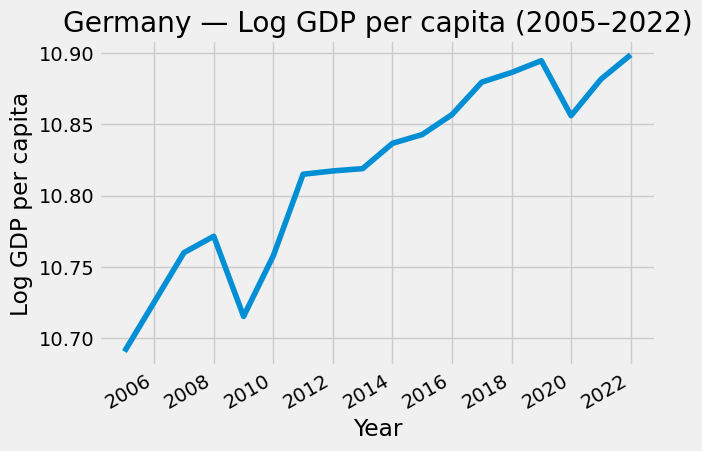

In [11]:
# Plot the data using matplotlib
plot_1 = ts.plot(title="Germany — Log GDP per capita (2005–2022)")
plt.xlabel("Year")
plt.ylabel("Log GDP per capita")
plt.show()


In [12]:

# Export visual
plot_1.figure.savefig(os.path.join(path,'04 Analysis', 'Visualisations', 'germany_gdp_time.png'))

## 3. Time-series Analysis: decomposition

In [13]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

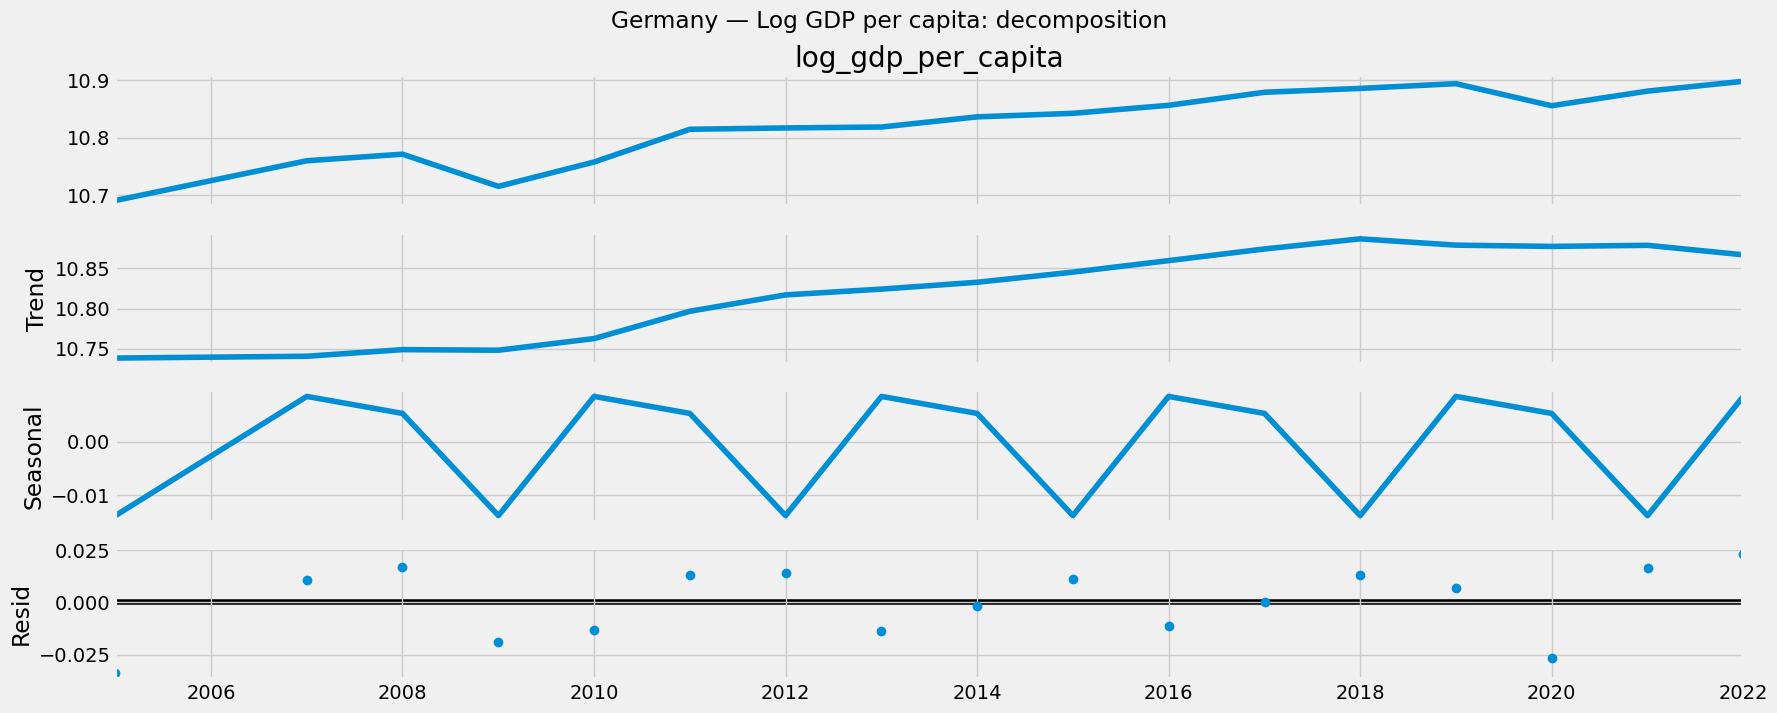

In [15]:
# Decompose the time series using an additive model
decomp = seasonal_decompose(ts, model='additive', period=3, extrapolate_trend='freq')

fig = decomp.plot()
fig.suptitle("Germany — Log GDP per capita: decomposition", y=1.02)
plt.show()

In [16]:
# Export
fig.figure.savefig(os.path.join(path,'04 Analysis', 'Visualisations', '_decomp_germany_gdp.png'))


Trend: A steady upward path across 2005–2022, with clear dips around 2009 (Global Financial Crisis) and 2020 (COVID-19), followed by recovery.

Seasonal: Zero as expected for annual data.

Residuals: Small, short-run deviations around the trend and slightly larger near crisis years.


The visible upward trend suggests the series is likely non-stationary in levels (mean changes over time). I will confirm with an ADF test 


## 4. Testing for stationarity

In [17]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

In [18]:
# Perform dickey_fuller test
def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries.dropna(), autolag='AIC')
    result = pd.Series(test[0:4],
                       index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key, value in test[4].items():
        result[f'Critical Value ({key})'] = value
    print(result)

# Run on original series
dickey_fuller(ts)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.565951
p-value                         0.500671
Number of Lags Used             5.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


ADF test (levels). Test statistic = −1.566; p = 0.501; critical values (5%) = −3.189. I fail to reject the unit-root null → the series in levels is non-stationary. I will difference the series and retest

In [19]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # import the autocorrelation and partial correlation plots

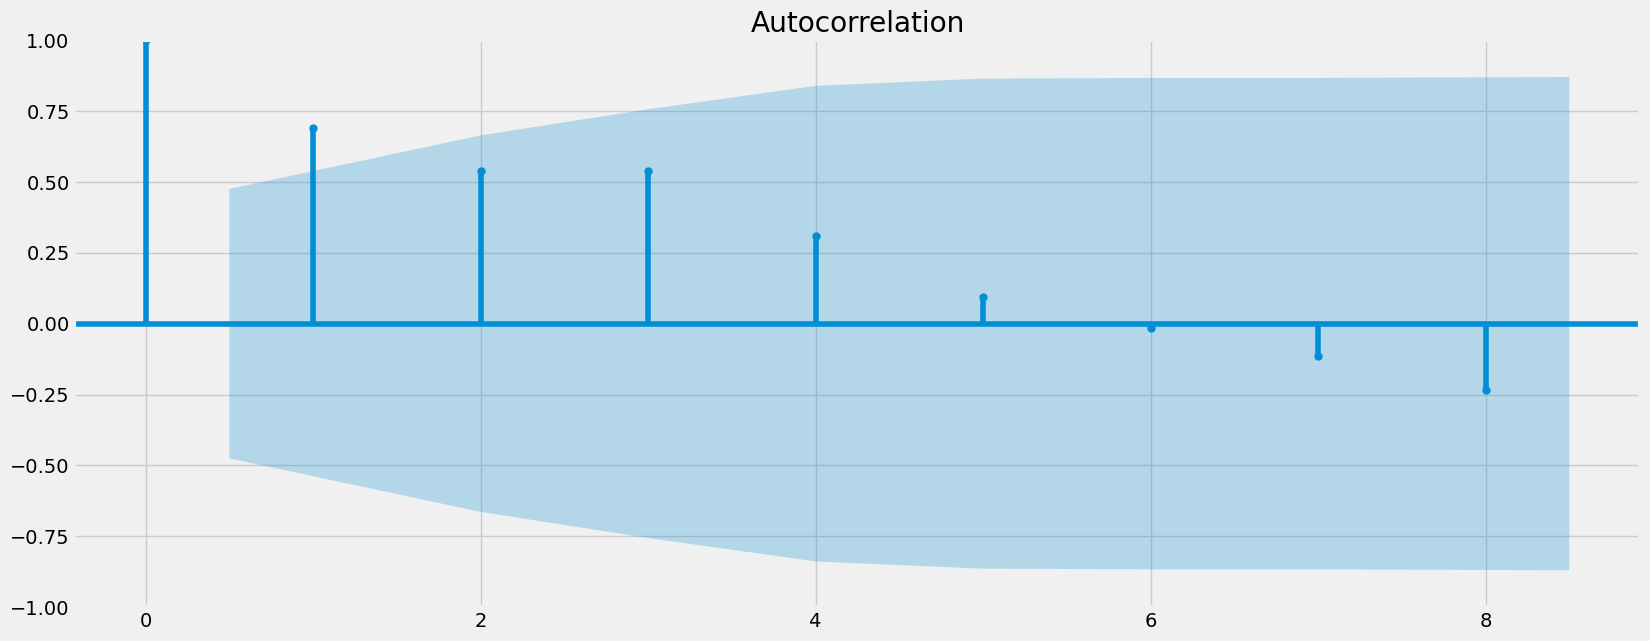

In [20]:
plot_acf(ts)
plt.show()

## 5. Stationarising the World Happiness Data

In [21]:
ts_diff1 = ts - ts.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [22]:
ts_diff1.dropna(inplace = True) # remove the missing values that came about as a result of the differencing.

In [23]:
ts_diff1.head()

year
2007-01-01    0.069249
2008-01-01    0.011455
2009-01-01   -0.056090
2010-01-01    0.042481
2011-01-01    0.057038
Name: log_gdp_per_capita, dtype: float64

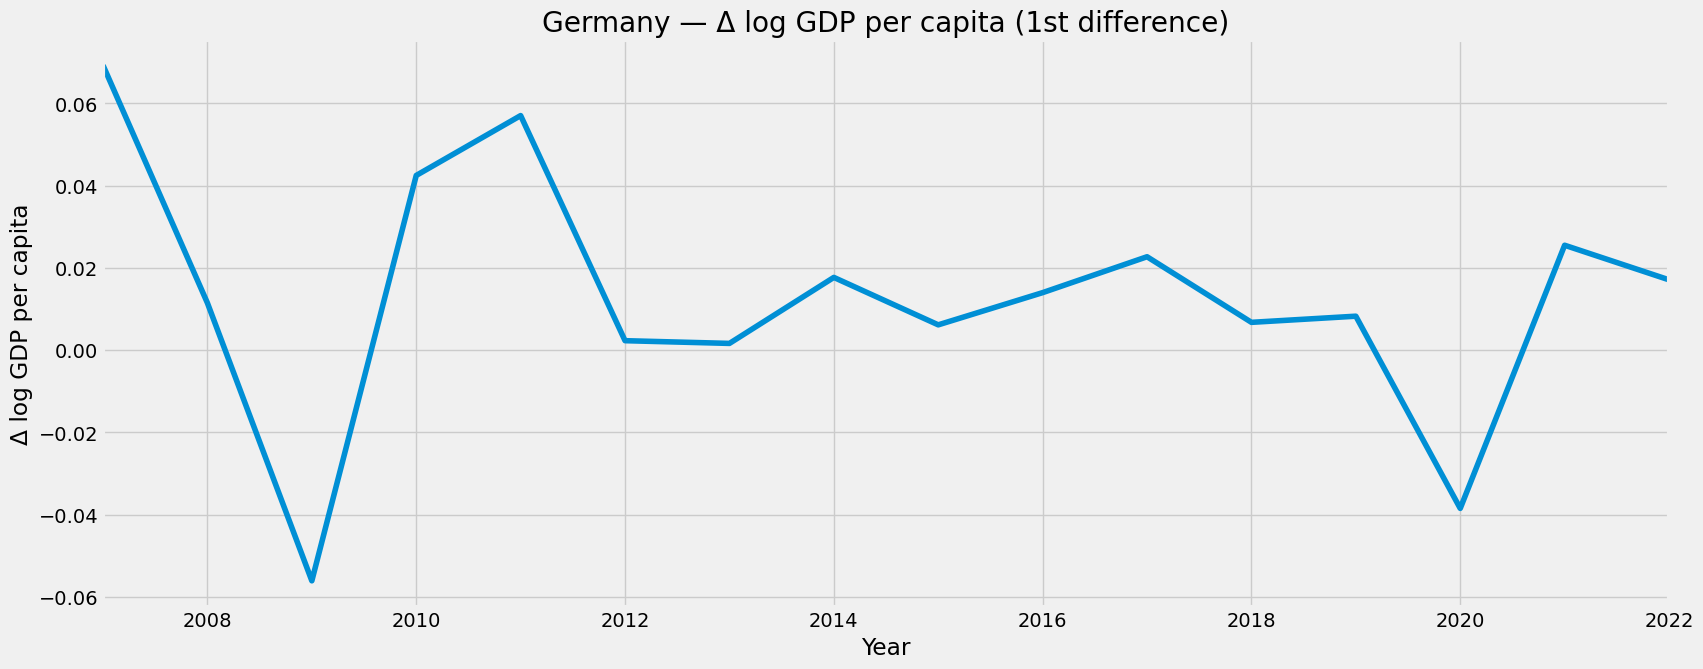

In [24]:
# Plot
plot_2 = ts_diff1.plot(title="Germany — Δ log GDP per capita (1st difference)")
plt.xlabel("Year"); 
plt.ylabel("Δ log GDP per capita"); 
plt.show()

In [25]:
# Export visual
plot_2.figure.savefig(os.path.join(path,'04 Analysis', 'Visualisations', 'germany_gdp_time_2.png'))

In [26]:
# ADF on the differenced series
dickey_fuller(ts_diff1)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.627753
p-value                         0.000115
Number of Lags Used             0.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


First differencing removed the trend and for a log series it approximates growth.
Because I am  using the years actually present in the dataset, any missing year means a difference spans >1 year. This is fine for the ADF test, but when interpreting as “annual growth” I must keep this in mind.

The first ADF: stat = −1.566, p = 0.501 -  failed to reject unit root - non-stationary.
The second ADF (1st difference): stat = −4.628, p = 0.000115 so it rejected unit root which means it is stationary after one difference.
Therefore,I’ll use the differenced series for autocorrelation diagnostics

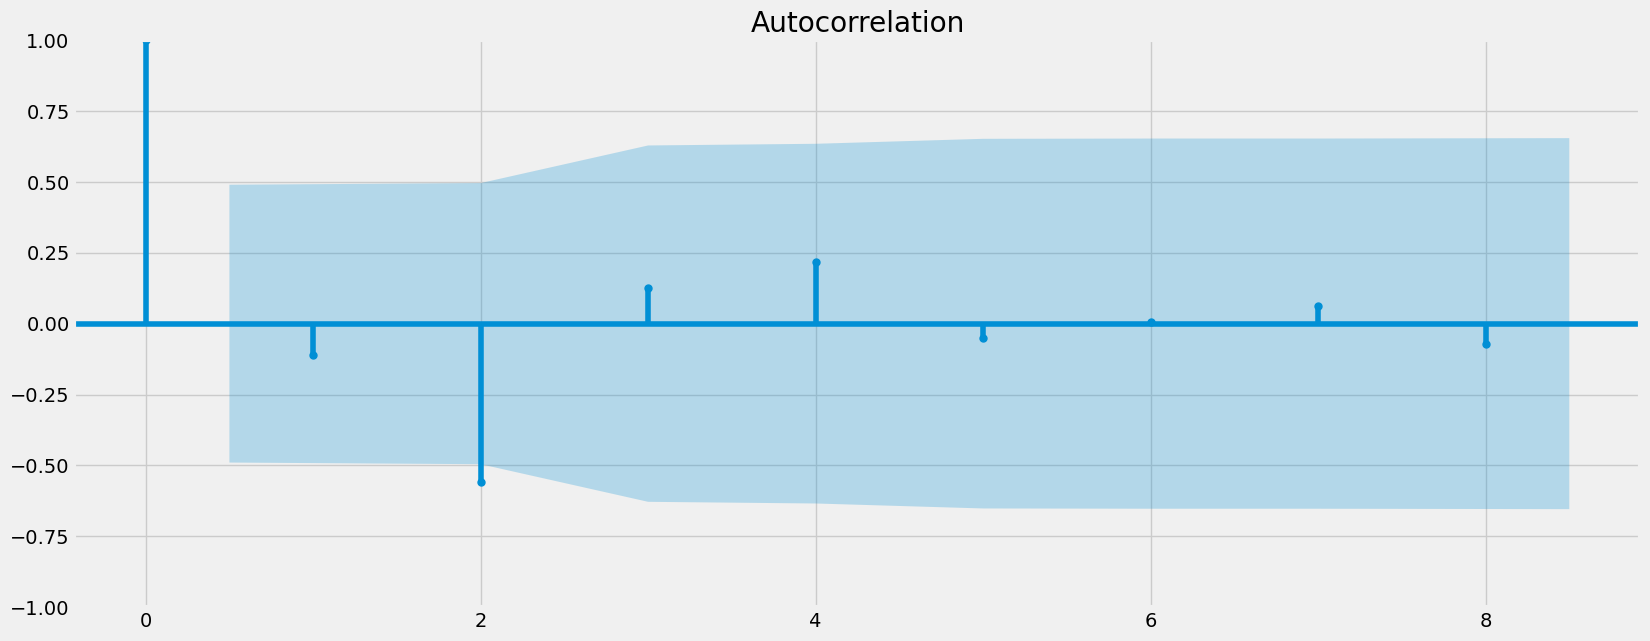

In [27]:
plot_acf(ts_diff1)
plt.show()

In [28]:
# Export untouched data
df.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'world_happiness.csv'))